And then

- do something with the "double check design matrix" and "first year talk" sections of this notebook
- get working with snakemake

# Analyzing the first-level results

After running our GLM analysis, we have the estimated amplitude responses of each voxel to each image class. Along with Noah Benson's anatomical template / Bayesian model, we also have each voxel's visual area and location in the visual field (in terms of eccentricity and polar angle). By combining the information contained within them, along with the dataframe describing each stimulus class, we can construct our tuning curves.

In [5]:
import pandas as pd
import nibabel as nib
import numpy as np
import seaborn as sns
%matplotlib inline
import sys
sys.path.append('..')
import sfp
import h5py
import os
import itertools
import pyPyrTools.JBhelpers as jbh
import pyPyrTools as ppt
import scipy as sp
from matplotlib.colors import LinearSegmentedColormap 

In [6]:
# This contains the information on each stimulus, allowing us to determine whether
# some stimuli are part of the same class or a separate one.
stim_df = pd.read_csv("../data/new_unshuffled_stim_description.csv", index_col=0)
# stim_df0= pd.read_csv('../data/stimuli_test/unshuffled_stim_description.csv', index_col=0)
# stim_df2= pd.read_csv('../data/stimuli_test2/unshuffled_stim_description.csv', index_col=0)

# Array full of the actual stimuli
stim = np.load('../data/new_unshuffled.npy')
# stim0 = np.load('../data/stimuli_test/unshuffled.npy')
# stim2 = np.load('../data/stimuli_test2/unshuffled.npy')

behav_results = h5py.File('../data/raw_behavioral/2017-Oct-09_wl_subj001_sess1.hdf5')

# for this, we just want any run, since they all contain the same classes and we don't care about their order
design_df, _, _ = sfp.design_matrices.create_design_df(behav_results, stim_df, 1)
design_df = design_df.reset_index(drop=True).sort_values(by="class_idx")
design_df = design_df[['w_r', 'w_a', 'class_idx', 'res']].set_index('class_idx')

stim_df = stim_df.set_index(['w_r', 'w_a'])
stim_df['class_idx'] = design_df.reset_index().set_index(['w_r', 'w_a'])['class_idx']
stim_df = stim_df.reset_index()

# stim_df0 = stim_df0.set_index(['w_r', 'w_a'])
# stim_df0['class_idx'] = design_df.reset_index().set_index(['w_r', 'w_a'])['class_idx']
# stim_df0 = stim_df0.reset_index()

In [7]:
df = pd.read_csv('../data/MRI_first_level/wl_subj001/summary_v1_e2-8_eccen_bin_hemi_bin.csv')
# df0 = pd.read_csv('../data/MRI_first_level/wl_subj001/summary_v1_e2-8_eccen_bin_hemi_bin_alpha0.csv')
# df2 = pd.read_csv('../data/MRI_first_level/wl_subj001/summary_v1_e2-8_eccen_bin_hemi_bin.csv')

Here we see the different stimulus classes, as plotted in frequency space, colored by their superclass. These numbers are roughly log-spaced (doubling).

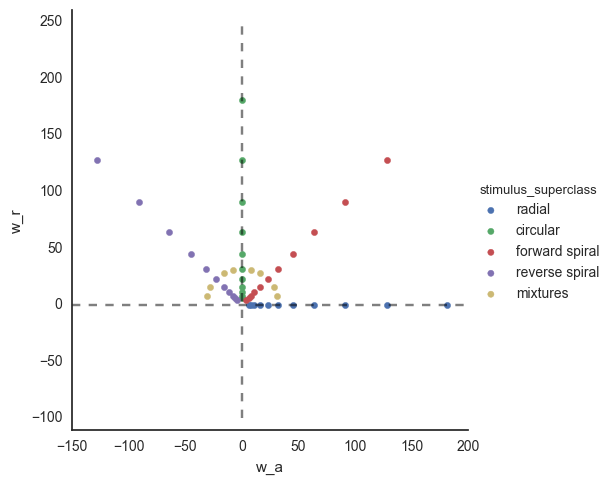

In [6]:
with sns.axes_style('white'):
    g = sns.FacetGrid(df[df.voxel==0], hue='stimulus_superclass', size=5, aspect=1)
    g.ax.plot([-150, 200], [0,0],'k--', alpha=.5)
    g.ax.plot([0, 0], [-100, 250], 'k--', alpha=.5)
    g.map(sns.plt.scatter, 'w_a', 'w_r')
    g.add_legend()
    _=g.ax.axis('equal')
    g.ax.set_xlim([-150, 200])
    g.ax.set_ylim([-100, 250])

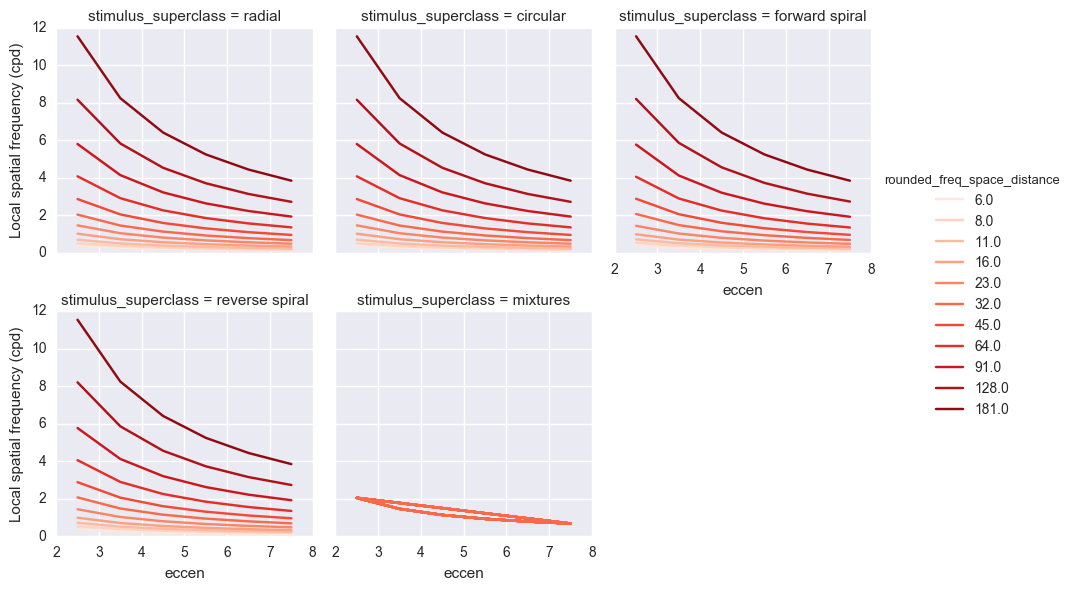

In [11]:
def mini_plot(x, y, **kwargs):
    x = [np.mean([float(j) for j in i.split('-')]) for i in x.values]
    sns.plt.plot(x, y.values, **kwargs)
g = sns.FacetGrid(df, hue='rounded_freq_space_distance', col='stimulus_superclass', palette='Reds', col_wrap=3)
g.map(mini_plot, 'eccen', 'Local spatial frequency (cpd)')
g.add_legend()

In [8]:
stim_idx = [stim_df[(stim_df.w_r==0)&(stim_df.w_a==181)].index[0]]
stim_idx.append(stim_df[(stim_df.w_r==181)&(stim_df.w_a==0)].index[0])
stim_idx.append(stim_df[(stim_df.w_r==128)&(stim_df.w_a==128)].index[0])
props = stim_df.loc[stim_idx]
tmp_stim = stim[stim_idx]
mags = []
angles = []
for (i, p), s in zip(props.iterrows(), tmp_stim):
    _, _, mag, angle = sfp.stimuli.create_sf_maps_cpp(p.res, p.w_r, p.w_a)
    mags.append(sfp.utils.mask_array_like_grating(s, mag, 128))
    angles.append(sfp.utils.mask_array_like_grating(s, angle, 128))

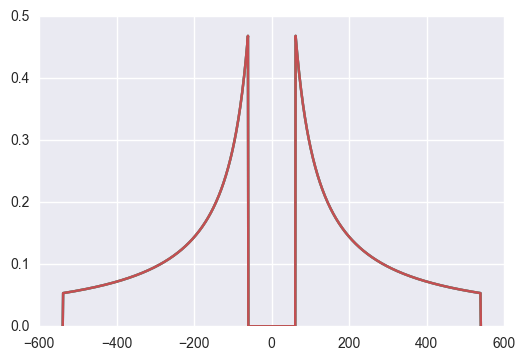

In [10]:
for i in range(3):
    sns.plt.plot(np.array(range(1,1081))-540, mags[i][540,:])

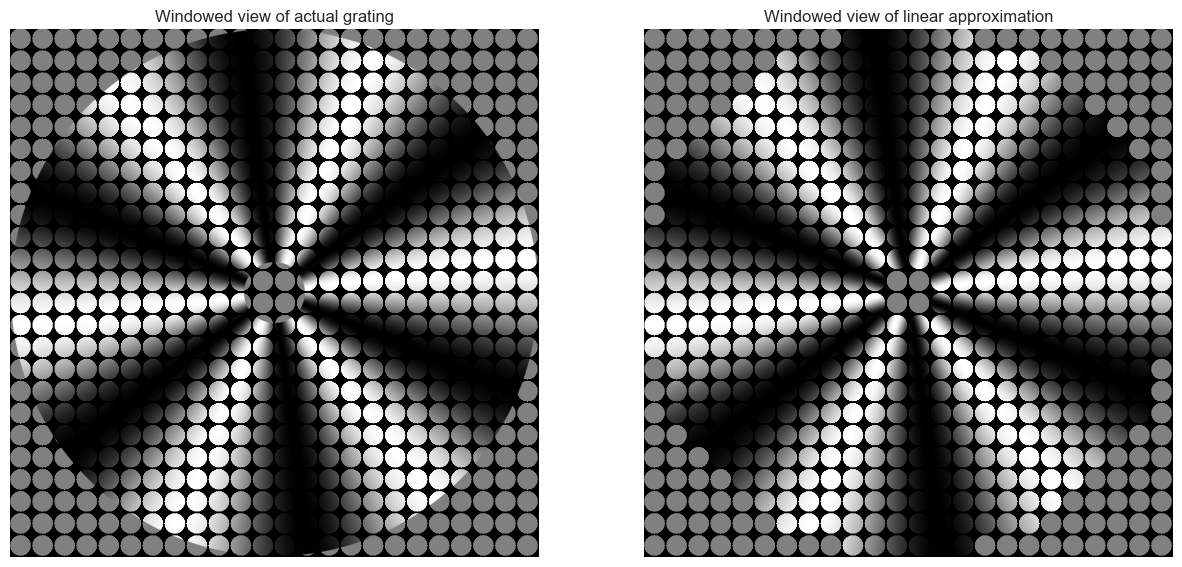

In [3]:
stim_idx = 1
props = stim_df.loc[stim_idx]
tmp_stim = stim[stim_idx]
dx, dy, _, _ = sfp.stimuli.create_sf_maps_cpp(props.res, props.w_r, props.w_a)
windowed_stim, windowed_approx = sfp.utils.plot_grating_approximation(tmp_stim, dx, dy, 24, props.phi, props.w_r, props.w_a, figsize=(15,10))

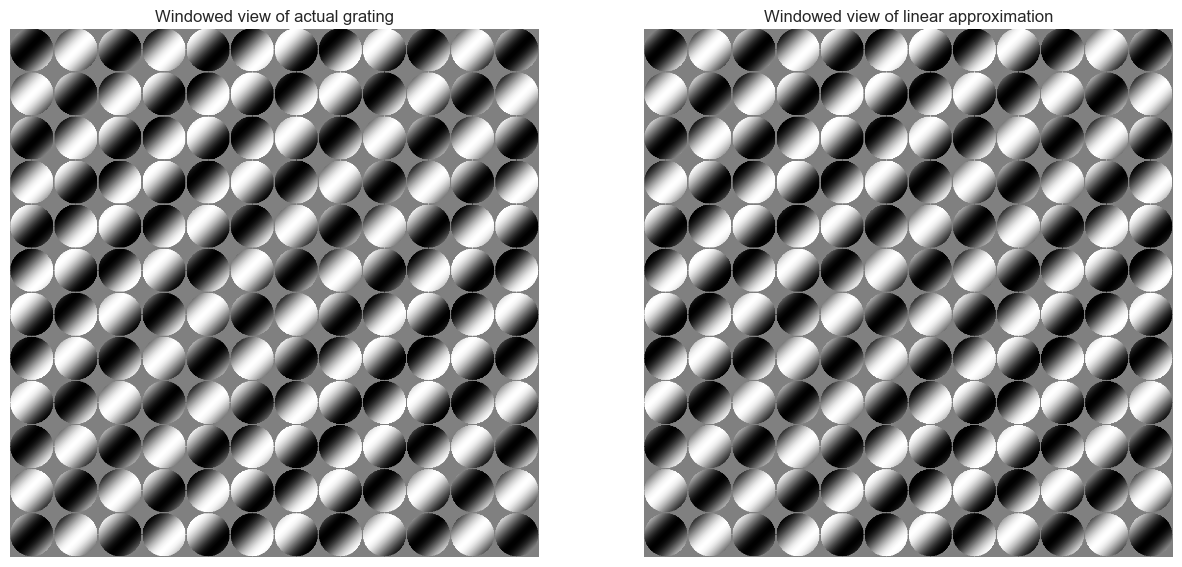

In [5]:
w_x, w_y = .005, .005
phase = np.pi
sin = sfp.utils.create_sin_cpp(1080, w_x, w_y, phase)
dy = w_x * np.ones((1080, 1080))
dx = w_y * np.ones((1080, 1080))
_=sfp.utils.plot_grating_approximation(sin, dx, dy, 12, phase, )

In [4]:
Rmin, Rmax = sfp.first_level_analysis.find_ecc_range_in_degrees(stim[0,:,:], 12)
print("Inside radius of stimulus annulus: %.02f" % Rmin)
print("Outside radius of stimulus annulus: %.02f" % Rmax)

Inside radius of stimulus annulus: 1.35
Outside radius of stimulus annulus: 12.00


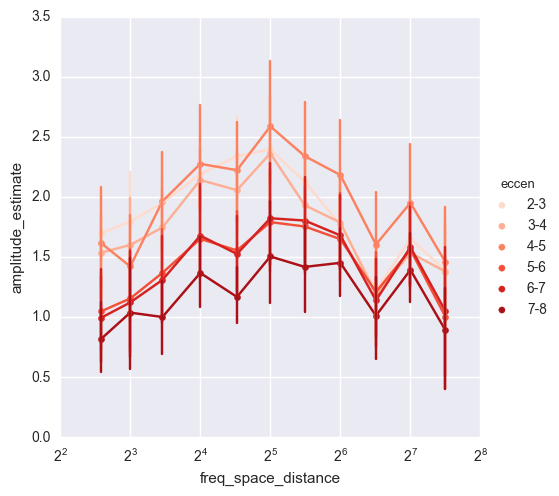

In [41]:
tmp_df = df[df.stimulus_superclass=='circular']
g = sns.FacetGrid(df, hue='eccen', palette='Reds', size=5,)
#g.map(sns.regplot, 'rounded_freq_space_distance', 'amplitude_estimate', x_estimator=np.mean, fit_reg=False)
g.map_dataframe(sfp.utils.plot_mean, 'rounded_freq_space_distance', 'amplitude_estimate')
g.map_dataframe(sfp.utils.scatter_ci_dist, 'freq_space_distance', 'amplitude_estimate')
for ax in g.axes.flatten():
    ax.set_xscale('log', basex=2)
g.add_legend()
g.fig.savefig('wl_subj042-raw.svg')

In [26]:
g = sns.FacetGrid(df, hue='eccen', palette='Reds', size=5, col='stimulus_superclass', col_wrap=2,
                  col_order=['circular', 'radial', 'forward spiral', 'reverse spiral', 'mixtures'])
#g.map(sns.regplot, 'freq_space_distance', 'amplitude_estimate', x_estimator=np.mean, fit_reg=False)
g.map_dataframe(sfp.utils.plot_mean, 'freq_space_distance', 'amplitude_estimate')
g.map_dataframe(sfp.utils.scatter_ci_dist, 'freq_space_distance', 'amplitude_estimate')
for ax in g.axes:
    ax.set_xscale('log', basex=2)
g.add_legend()

ValueError: Data has no positive values, and therefore can not be log-scaled.

ValueError: Data has no positive values, and therefore can not be log-scaled.

If there were no scaling in the visual system, such that neurons at different places in the visual field were expected to have similar properties, the bottom would all line up well, and it doesn't!


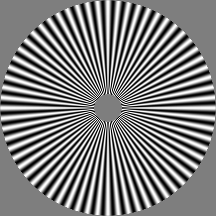
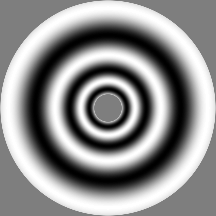
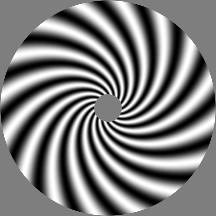
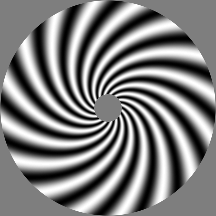

In [17]:
classes_of_interest = []
classes_of_interest.extend(df[(df.stimulus_superclass=='circular')&(df.rounded_freq_space_distance==11)].stimulus_class.unique())
classes_of_interest.extend(df[(df.stimulus_superclass=='radial')&(df.rounded_freq_space_distance==64)].stimulus_class.unique())
classes_of_interest.extend(df[(df.stimulus_superclass=='forward spiral')&(df.rounded_freq_space_distance==23)].stimulus_class.unique())
classes_of_interest.extend(df[(df.stimulus_superclass=='reverse spiral')&(df.rounded_freq_space_distance==23)].stimulus_class.unique())
#classes_of_interest.append(df[df.stimulus_superclass=='mixtures'].stimulus_class.values[0])

stim_idxs = stim_df[stim_df.class_idx.isin(classes_of_interest)].index.values[::8]

jbh.showIm([stim[i, :, :] for i in stim_idxs], ncols=4, zoom=.2)

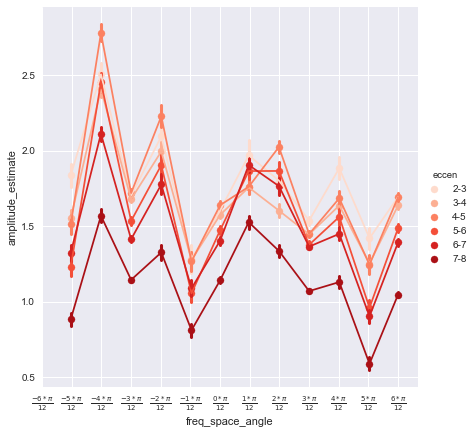

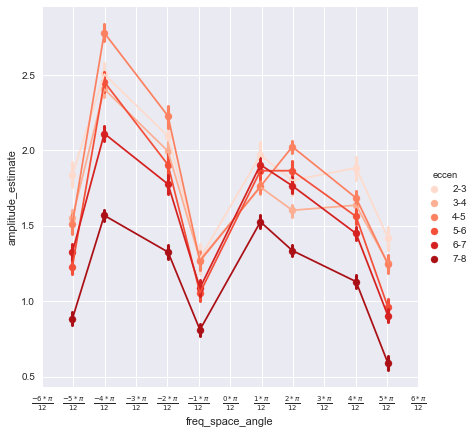

In [52]:
# I know this goes from about -pi/2 to pi/2, in pi/12 steps
ticks = [(np.pi*(i-6)/12.) for i in range(13)]
labels = ['$\\frac{%s*\\pi}{12}$'%(i-6) for i in range(13)]

g = sns.FacetGrid(df, hue='eccen', palette='Reds', size=6)
g.map(sns.regplot, 'freq_space_angle', 'amplitude_estimate', x_estimator=np.mean, fit_reg=False)
g.map_dataframe(sfp.utils.plot_mean, 'freq_space_angle', 'amplitude_estimate')
#g.map_dataframe(sfp.utils.scatter_ci, 'freq_space_angle', 'amplitude_estimate_median', 'amplitude_estimate_std_error') 
_=g.ax.set_xticks(ticks)
_=g.ax.set_xticklabels(labels)
g.add_legend()

# I know this goes from about -pi/2 to pi/2, in pi/12 steps
ticks = [(np.pi*(i-6)/12.) for i in range(13)]
labels = ['$\\frac{%s*\\pi}{12}$'%(i-6) for i in range(13)]

tmp_df = df[df.stimulus_superclass=='mixtures']
g = sns.FacetGrid(tmp_df, hue='eccen', palette='Reds', size=6)
g.map(sns.regplot, 'freq_space_angle', 'amplitude_estimate', x_estimator=np.mean, fit_reg=False)
g.map_dataframe(sfp.utils.plot_mean, 'freq_space_angle', 'amplitude_estimate')
#g.map_dataframe(sfp.utils.scatter_ci, 'freq_space_angle', 'amplitude_estimate_median', 'amplitude_estimate_std_error') 
_=g.ax.set_xticks(ticks)
_=g.ax.set_xticklabels(labels)
g.add_legend()


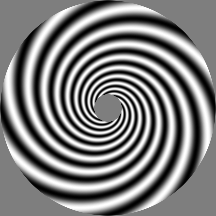
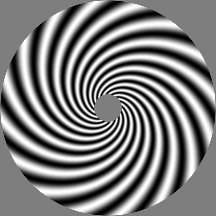
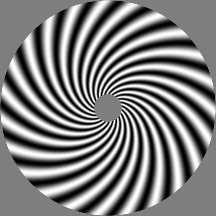
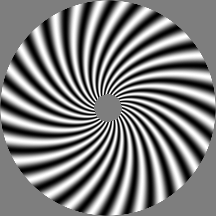
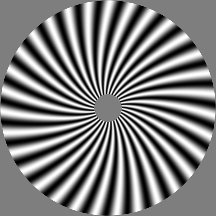
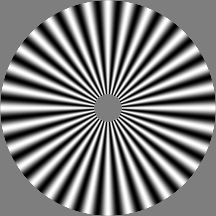
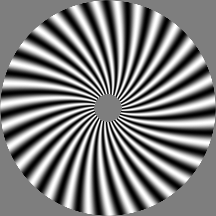
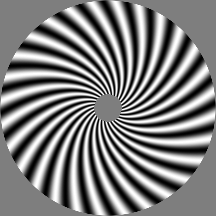
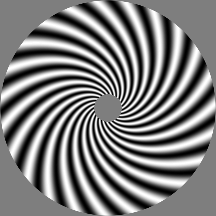
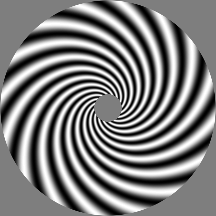
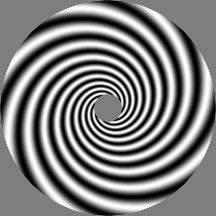
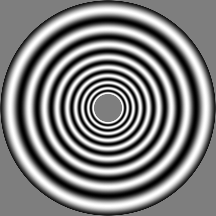

In [85]:
angles = sorted(df.freq_space_angle.unique())
stim_idxs = []
for ang in angles:
    class_of_interest = df[(df.freq_space_angle==ang)&(df.rounded_freq_space_distance==32)].stimulus_class.unique()[0]
    stim_idxs.append(stim_df[stim_df.class_idx==class_of_interest].index[0])

#stim_idxs = stim_df[stim_df.class_idx.isin(classes_of_interest)].index.values[::8]

jbh.showIm([stim[i, :, :] for i in stim_idxs], ncols=4, zoom=.2)

/home/billbrod/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


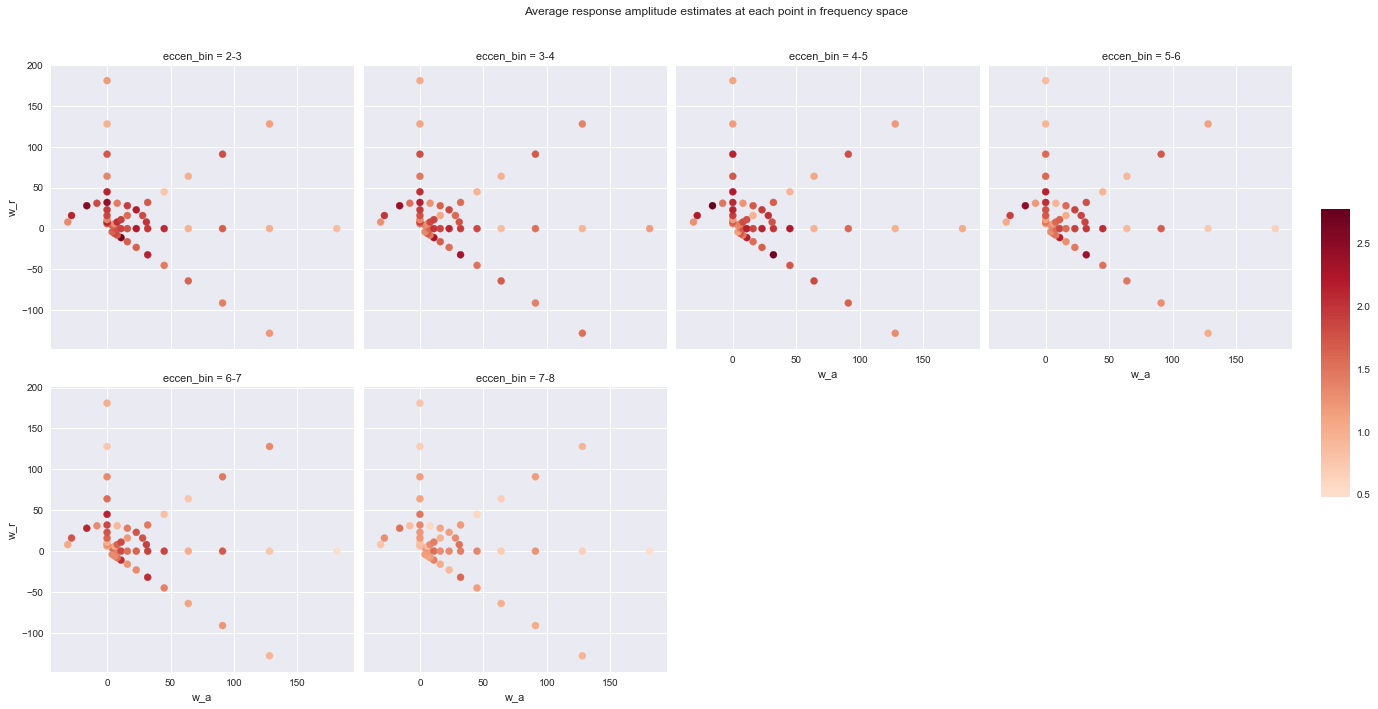

In [16]:
tmp_df = pd.DataFrame(df.groupby(['eccen_bin', 'w_r', 'w_a']).modelmd.mean()).reset_index()

g = sns.FacetGrid(tmp_df, col='eccen_bin', col_wrap=4, size=5)
cbar_ax = g.fig.add_axes([.92, .3, .02, .4])  # <-- Create a colorbar axes
g.map(sfp.utils.scatter_heat, 'w_a', 'w_r', 'amplitude_estimate_median', vmin=tmp_df['amplitude_estimate_median'].min(), 
      vmax=tmp_df['amplitude_estimate_median'].max())
sns.plt.colorbar(cax=cbar_ax)
g.fig.subplots_adjust(right=.9, top=.9)
g.fig.suptitle('Average response amplitude estimates at each point in frequency space')

In [17]:
tmp_df = pd.pivot_table(df, 'amplitude_estimate_median', 'rounded_freq_space_distance', 'eccen_bin')
norm_df = tmp_df.copy()
for col in norm_df.columns:
    norm_df[col] = norm_df[col] / norm_df[col].max()

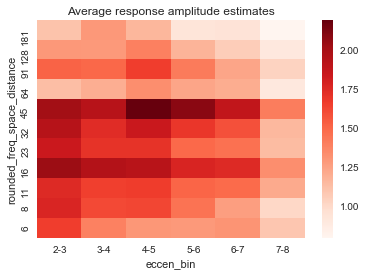

In [80]:
fig = sns.heatmap(tmp_df, cmap='Reds')
fig.invert_yaxis()
fig.set_title('Average response amplitude estimates')

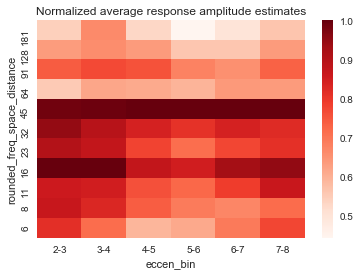

In [81]:
fig = sns.heatmap(norm_df, cmap='Reds')
fig.invert_yaxis()
fig.set_title('Normalized average response amplitude estimates')

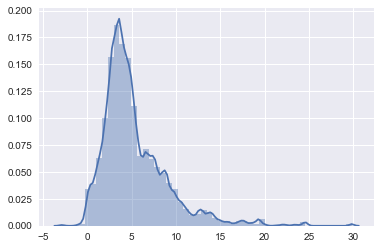

In [20]:
sns.distplot(df.R2.values)

# Create plots for first year talk

In [24]:
# for this, we're only using circular results
tmp_df = df[df.stimulus_superclass=='circular']
# tmp_df = tmp_df[['eccen', 'amplitude_estimate', 'freq_space_distance', 'Local spatial frequency (cpd)', 'bootstrap_num', 'hemi']]
tmp_df = tmp_df[['eccen', 'amplitude_estimate', 'freq_space_distance', 'Local spatial frequency (cpd)', 'bootstrap_num']]

In [8]:
tmper_df = tmp_df[tmp_df.freq_space_distance==6.]
tmper_df = tmper_df.groupby(['eccen', 'bootstrap_num'])['amplitude_estimate'].mean().unstack().reset_index()

In [9]:
hyp_df = pd.melt(tmp_df, ['eccen', 'amplitude_estimate', 'bootstrap_num'], var_name='Frequency')
hyp_df = pd.DataFrame(hyp_df.groupby(['Frequency', 'value', 'bootstrap_num'])['amplitude_estimate'].mean()).reset_index()

In [10]:
print("freq_space_distance min: %.03f, max: %.03f" % (tmp_df.freq_space_distance.min(), tmp_df.freq_space_distance.max()))
print("Halfway in log space: %.03f" % np.floor(2**((np.log2(181.) + np.log2(6.))/2.)))
# because these are circular, freq_space_distance==w_r
#stim_idx = stim_df[(stim_df.w_r.isin([6, 32, 181]))&(stim_df.w_a==0)].index[::8]
stim_idx = stim_df[(stim_df.w_r.isin([6, 32, ]))&(stim_df.w_a==0)].index[::8]
stims = [stim[i] for i in stim_idx]

freq_space_distance min: 6.000, max: 181.000
Halfway in log space: 32.000


We actually want to plot windows of the stimuli instead of just sins

In [11]:
max_degree_rad = 12
scale_factor = 10
mask = sfp.utils.create_circle_mask(750, 350, scale_factor* 1080/(2*2*max_degree_rad), 1080)
stim_windows = [mask * s + ~mask.astype(bool)*127 for s in stims]


In [12]:
import warnings
def fit_log_norm_ci(x, y, ci_vals=[2.5, 97.5], **kwargs):
    """fit log norm to data and plot the result

    to be used with seaborn.FacetGrid.map_dataframe
    """
    data = kwargs.pop('data')
    color = kwargs.pop('color')
    lines = []
    # we want to collapse hemispheres -- eventually this should be moved earlier
    tmp = pd.DataFrame(data.groupby([x, 'bootstrap_num'])[y].mean()).reset_index()
    for boot in data.bootstrap_num.unique():
        plot_data = tmp.groupby(x)[[y, 'bootstrap_num']].apply(lambda x, j: x[x.bootstrap_num==j], boot)
        plot_idx = plot_data.index.get_level_values(x)
        plot_vals = plot_data[y].values
        try:
            popt, _ = sp.optimize.curve_fit(sfp.utils.log_norm_pdf, plot_idx, plot_vals)
        except RuntimeError:
            warnings.warn("For eccentricity %s and frequency space %s, bootstrap %d was not well fit by a log Gaussian and so is skipped" % (data['Eccentricity (degrees)'].unique()[0], data['Frequency'].unique()[0], boot))
        else:
            lines.append(sfp.utils.log_norm_pdf(plot_idx, *popt))
    lines = np.array(lines)
    lines_mean = lines.mean(0)
    cis = np.percentile(lines, ci_vals, 0)
    sns.plt.fill_between(plot_idx, cis[0], cis[1], facecolor=color, alpha=.2, **kwargs)
    sns.plt.plot(plot_idx, lines_mean, color=color, **kwargs)
    return lines

In [15]:
def compare_hypotheses(df, axis_imgs=None, **kwargs):
    """
    axis_imgs should be a 2d list / array containing 2-tuples. each tuple should contain the relative position of each
        image and the corresponding image to put on an axis. the first dimension corresponds to the first axis, the second
        to the second axis
    """
    tmp_df = df[df.stimulus_superclass=='circular']
#    tmp_df = tmp_df[['eccen', 'amplitude_estimate', 'freq_space_distance', 'Local spatial frequency (cpd)', 'bootstrap_num', 'hemi']]
#    tmp_df = pd.melt(tmp_df, ['eccen', 'amplitude_estimate', 'bootstrap_num', 'hemi'], var_name='Frequency')
    tmp_df = tmp_df[['eccen', 'amplitude_estimate', 'freq_space_distance', 'Local spatial frequency (cpd)', 'bootstrap_num',]]
    tmp_df = pd.melt(tmp_df, ['eccen', 'amplitude_estimate', 'bootstrap_num',], var_name='Frequency')
    tmp_df = tmp_df.rename(columns={'eccen': 'Eccentricity (degrees)'})

    g = sns.FacetGrid(tmp_df, hue='Eccentricity (degrees)', row='Frequency',  palette='Reds', size=5, aspect=2, sharex=False,
                      row_order=['Local spatial frequency (cpd)', 'freq_space_distance'])
    #g.map_dataframe(sfp.utils.plot_mean, 'value', 'amplitude_estimate')
    #g.map_dataframe(sfp.utils.scatter_ci_dist, 'value', 'amplitude_estimate', [50, 50])
    g.map_dataframe(fit_log_norm_ci, 'value', 'amplitude_estimate', ci_vals=[16, 84])
    g.map(sns.regplot, 'value', 'amplitude_estimate', x_estimator=np.mean, fit_reg=False, ci=0)
    sns.plt.subplots_adjust(hspace=.6)
    for i, ax in enumerate(g.axes.flatten()):
        if i==1:
            ax.set_title('Response as function of stimulus')
        elif i==0:
            ax.set_xlim([2**-3.5, 2**4])
            ax.set_title('Response as function of local spatial frequency (cycles / degree)')
        ax.set_xscale('log', basex=2)
        for pos, img in axis_imgs[i]:
            sfp.utils.add_img_to_xaxis(g.fig, ax, img, pos, vmin=0, vmax=255, size=.15)
        ax.xaxis.set_visible(False)
        ax.set_ylabel("Response amplitude estimate")
    #g.ax.set_xlim([2**-3, 2**3.5])
    g.add_legend()
    return g

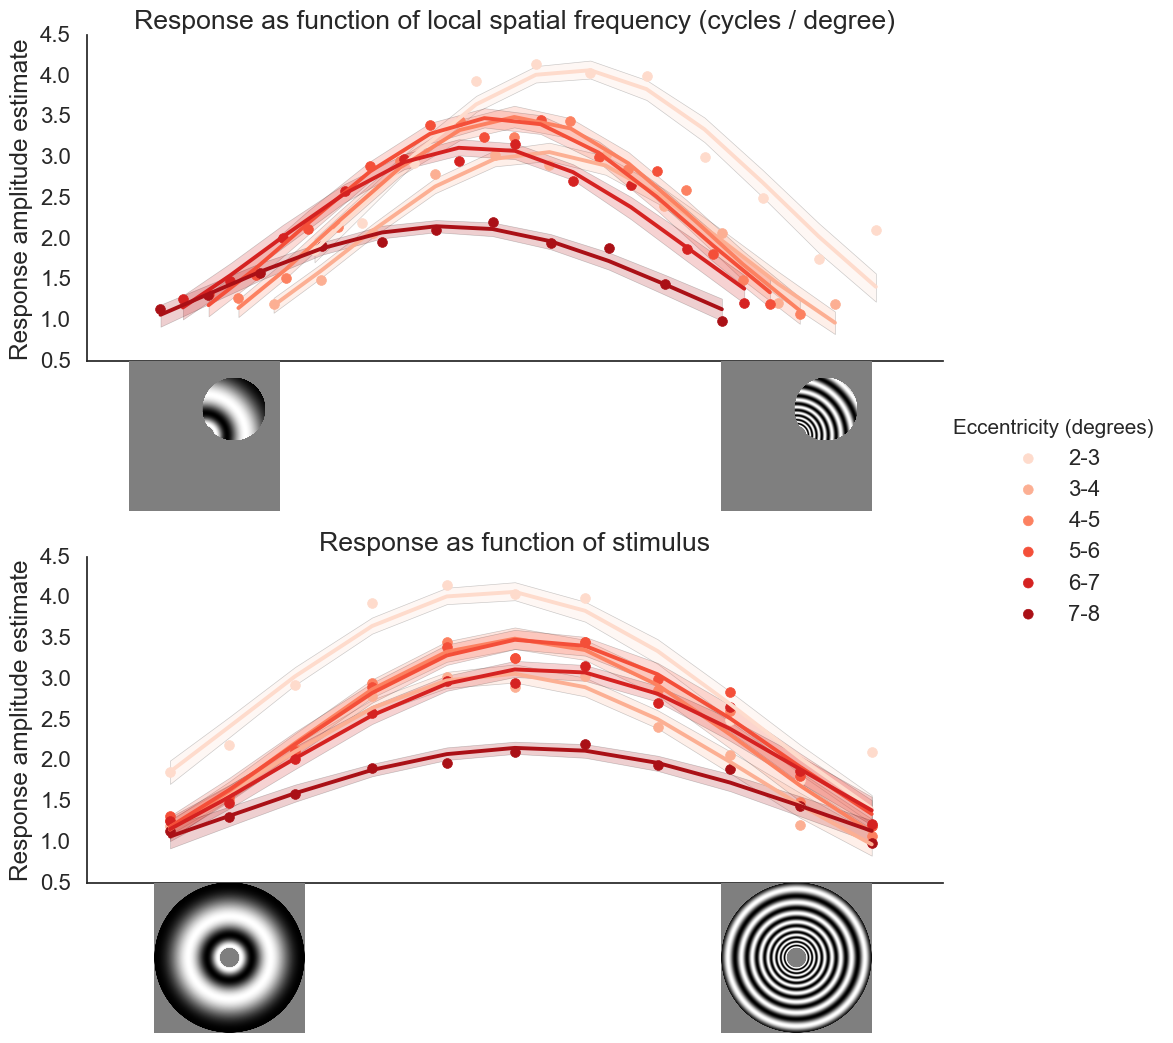

In [34]:
with sns.plotting_context('poster'), sns.axes_style('white'):
    g = compare_hypotheses(df, [zip([.025, .6], stim_windows), zip([.05, .6], stims)])
    g.savefig('SF-wl_subj045-results.svg')

In [25]:
tmper_df = tmp_df[['Local spatial frequency (cpd)', 'amplitude_estimate', 'eccen']]

def fit_lnorm(data):
    popt, pcov = sp.optimize.curve_fit(sfp.utils.log_norm_pdf, data.index, data.values)
    return sfp.utils.log_norm_pdf(data.index, *popt), popt


bandwidth = []
peak = []
for n, g in tmper_df.groupby('eccen'):
    mn_data = g.groupby(['Local spatial frequency (cpd)'])['amplitude_estimate'].mean()
    fit_data, params = fit_lnorm(mn_data)
    peak.append([n, mn_data.index[np.argmax(fit_data.values)]])
    bandwidth.append([n, np.exp(params[2])])

peak = np.array([((int(i[0])+int(i[2]))/2., j) for i,j in peak])
bandwidth = np.array([((int(i[0])+int(i[2]))/2., j) for i,j in bandwidth])
print peak
print bandwidth

[[ 2.5         2.64442929]
 [ 3.5         2.06290022]
 [ 4.5         1.66656346]
 [ 5.5         1.39038784]
 [ 6.5         1.18985363]
 [ 7.5         1.03866873]]
[[ 2.5         8.77035836]
 [ 3.5         5.99299614]
 [ 4.5         5.31013856]
 [ 5.5         4.95075735]
 [ 6.5         5.05662369]
 [ 7.5         4.48668172]]


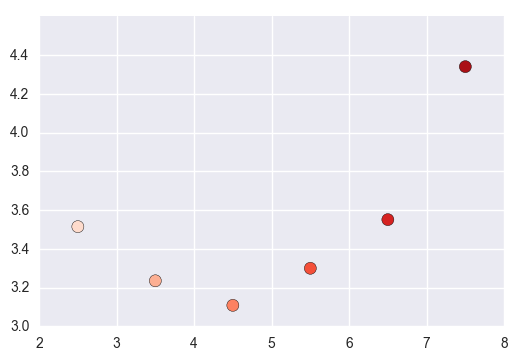

In [30]:
sns.plt.scatter(bandwidth[:,0], bandwidth[:,1], c=sns.color_palette('Reds', 6), s=75)

In [26]:
def hyperbola(x, a):
    b = 1.
    period = x*a
    period[x<b] = a*b
    return 1./period

def fit_hyperbola(peak):
    popt, pcov = sp.optimize.curve_fit(hyperbola, peak[:,0], peak[:,1])
    return popt

opt_a = fit_hyperbola(peak)

In [27]:
peak_01 = peak
opt_a_01 = opt_a

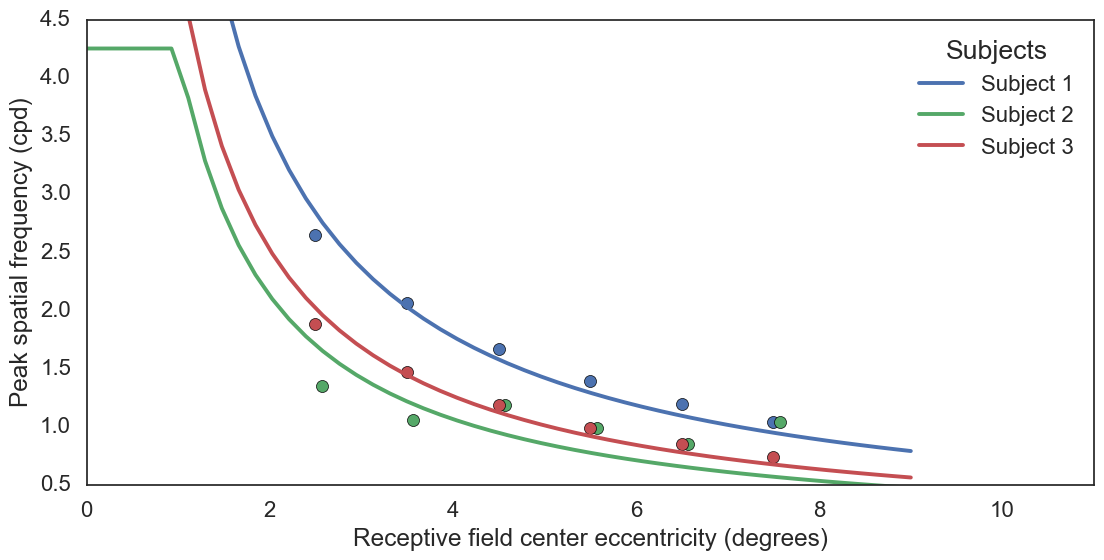

In [28]:
ecc = np.linspace(.01, 9, 50)
RF_scale_factor = 4.
V1_RF_size = np.concatenate([np.ones(len(ecc[ecc<.5]))/RF_scale_factor, np.linspace(1/RF_scale_factor, 4/RF_scale_factor, len(ecc[ecc>=.5]))])
#V2_RF_size = np.concatenate([2*np.ones(len(ecc[ecc<4])), np.linspace(2, 2.5, len(ecc[ecc>=4]))])

Olsson_peak = [2.75, 2.11, 1.76, 1.47,1.24, 1.06, .88, .77, .66, .60]
Olsson_ecc = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

with sns.plotting_context('poster', font_scale=1), sns.axes_style('white'):
    # because this doesn't represent data, just intuition, we use this.
#    with plt.xkcd():
    x = np.linspace(.01, 9, 50)
    y = []
    fig, axes = sns.plt.subplots(1,1, figsize=(13,6))
    ax = axes
    # this gives intuitive plots, currently we want the possible hypotheses instead
#         for i in range(3):
#             y.append(10/(x+2)+i)
#             ax.plot(x, y[-1],  label='V%s'%(i+1), color=['r','g','b'][i])
    colors = sns.color_palette(n_colors=3)
    for i, (p, o) in enumerate([[peak_01, opt_a_01], [peak_42, opt_a_42], [peak_45, opt_a_45]]):
#    ax.plot(ecc, hyperbola(ecc, opt_a), '-', label='scaling')
#        ax.plot(ecc, hyperbola(ecc, o), '-', label='scaling', c= colors[i])
        ax.plot(ecc, hyperbola(ecc, o), '-', label='Subject %s'%(i+1), c= colors[i])
#    ax.plot(ecc, np.ones(len(ecc))*RF_scale_factor, '--', label='constant')
#        ax.set_ylim((0,8))
#    sns.plt.scatter(peak[:, 0], peak[:, 1], c=sns.color_palette('Reds', 6), s=75,)# label='This study')
        if i==1:
            sns.plt.scatter(p[:, 0]+.07, p[:, 1], c=colors[i], s=75,)# label='This study')
        else:
            sns.plt.scatter(p[:, 0], p[:, 1], c=colors[i], s=75,)# label='This study')
#    sns.plt.scatter(Olsson_ecc, Olsson_peak, s=75, c= sns.color_palette('Blues', 10), label='Olsson pilot')
    ax.set_xlabel("Receptive field center eccentricity (degrees)")
    ax.set_ylabel("Peak spatial frequency (cpd)")
    ax.set_title("")
    ax.set_ylim((.5, 4.5))
    ax.set_xlim((0, 11))

    sns.plt.legend(title="Subjects", loc='best')
    ax.figure.savefig('results-hypotheses.svg', bbox_inches='tight')

# Double-check design matrix

In order to use this, run everything except for the `sfp.experiment.run` statement first, which will create pictures, one from each class, in the order the `design_df` thinks they are presented. Then run the `sfp.experiment.run` block on a two-monitor setup so one monitor can display the experiment while you have this notebook open in the other. This will allow you to make sure the stimuli are being ordered correctly.

You can also compare `design_df.index.values` to a picture of the design matrix to make sure things got transferred correctly there as well.

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import sys
sys.path.append('..')
import sfp
import h5py
import os
import pyPyrTools.JBhelpers as jbh

In [3]:
# This file contains the button presses (which also show the TR onsets) 
# and the order the stimuli were presented in (along with their timing)
behav_results = h5py.File('../data/raw_behavioral/2017-Aug-23_Noah_sess1.hdf5')

# This contains the information on each stimulus, allowing us to determine whether
# some stimuli are part of the same class or a separate one.
stim_df = pd.read_csv("../data/stimuli/unshuffled_stim_description.csv", index_col=0)

# Array full of the actual stimuli
stim = np.load('../data/stimuli/unshuffled.npy')

# for this, we just want any run, since they all contain the same classes and we don't care about their order
design_df, stim_length, TR = sfp.first_level_analysis.create_design_df(behav_results, stim_df, 1, drop_blanks=False)
design_df = design_df.reset_index(drop=True).set_index("class_idx")

stim_df['class_idx'] = np.floor(stim_df['index']/8)
stim_df = stim_df.set_index('class_idx')
stim_df['Onset time (TR)'] = design_df['Onset time (TR)']
stim_df = stim_df.reset_index().sort('Onset time (TR)')

stim_df = stim_df.drop_duplicates('class_idx')
stim_idx = stim_df.index.values

../sfp/first_level_analysis.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  design_df['Onset time (TR)'] = np.where(time_from_TR == 0)[1]
/home/billbrod/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [41]:
data = sfp.experiment.run('../data/stimuli/unshuffled.npy', '../data/stimuli/Noah_run01_idx.npy', None, screen=0)

499.7961 	WARNING 	User requested fullscreen with size [1920 1080], but screen is actually [1920, 1200]. Using actual size
502.1392 	WARNING 	Couldn't measure a consistent frame rate.
  - Is your graphics card set to sync to vertical blank?
  - Are you running other processes on your computer?

502.1521 	ERROR 	Unknown colorSpace: None
502.2874 	WARNING 	t of last frame was 148.41ms (=1/6)
509.5404 	WARNING 	t of last frame was 7253.03ms (=1/0)
509.8382 	WARNING 	t of last frame was 297.80ms (=1/3)
510.0393 	WARNING 	t of last frame was 201.10ms (=1/4)
510.3369 	WARNING 	Multiple dropped frames have occurred - I'll stop bothering you about them!



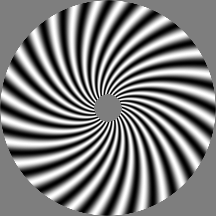
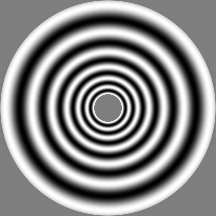
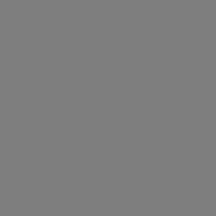
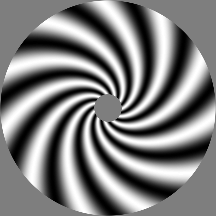
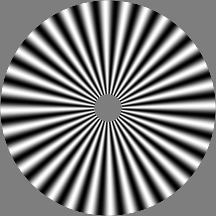
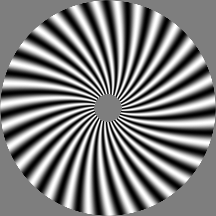
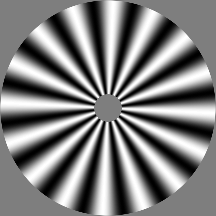
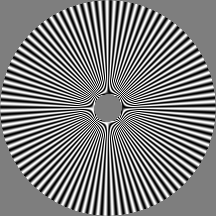
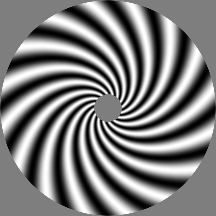
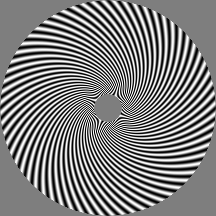

In [33]:
jbh.showIm([stim[i,:,:] for i in stim_idx[:10]], ncols=5, zoom=.2)


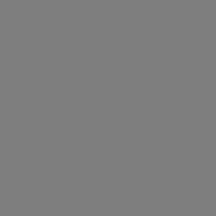
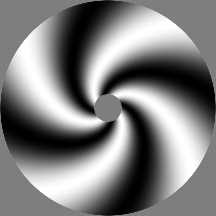
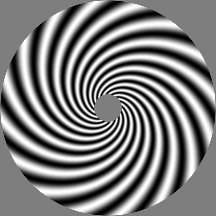
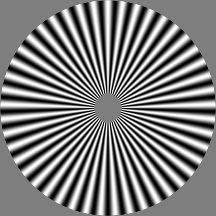
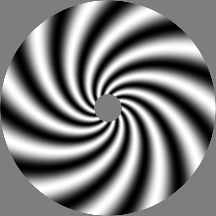
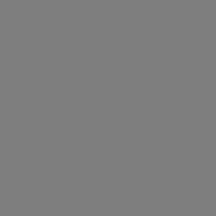
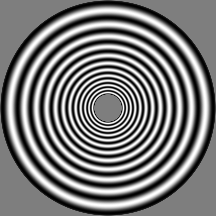
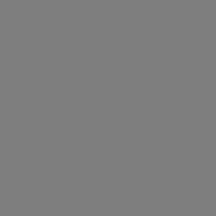
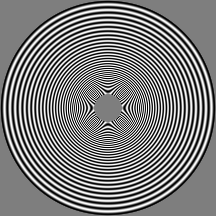
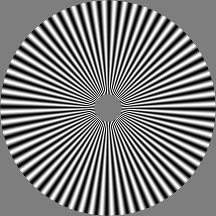

In [34]:
jbh.showIm([stim[i,:,:] for i in stim_idx[10:20]], ncols=5, zoom=.2)


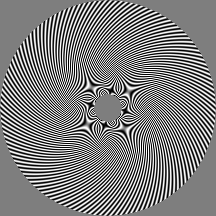
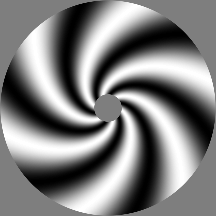
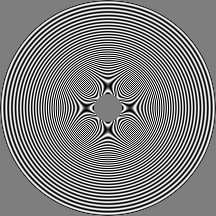
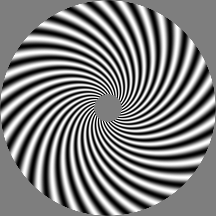
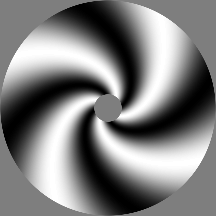
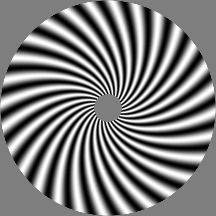
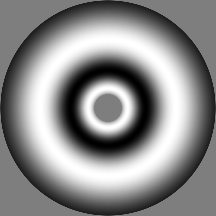
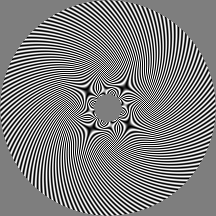
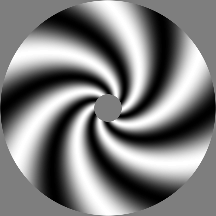
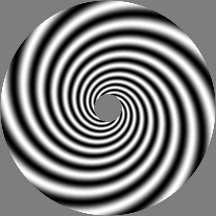

In [35]:
jbh.showIm([stim[i,:,:] for i in stim_idx[20:30]], ncols=5, zoom=.2)


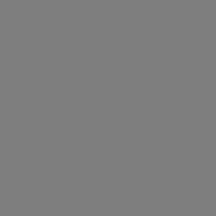
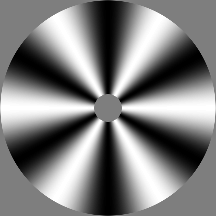
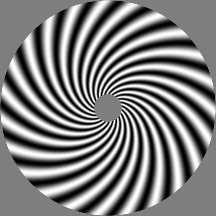
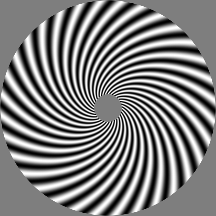
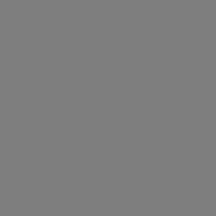
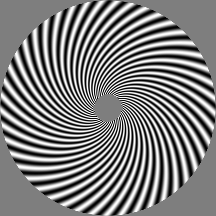
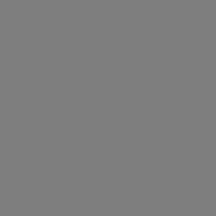
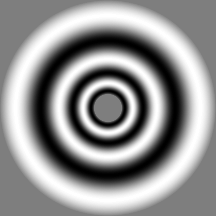
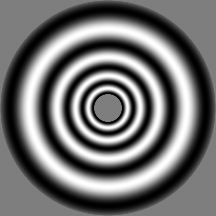
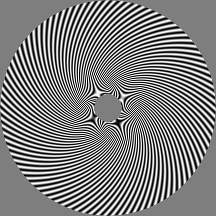

In [36]:
jbh.showIm([stim[i,:,:] for i in stim_idx[30:40]], ncols=5, zoom=.2)


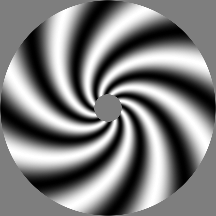
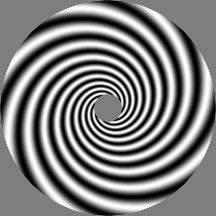
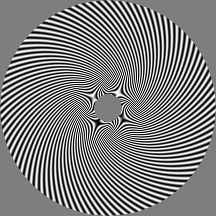
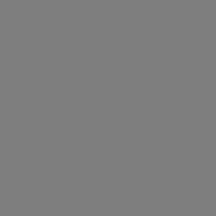
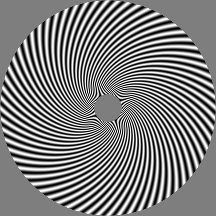
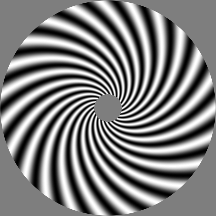
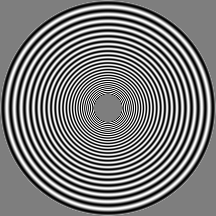
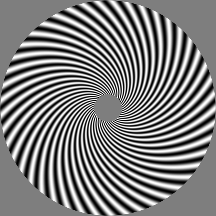
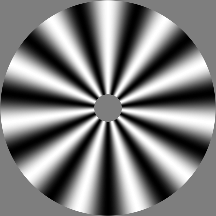
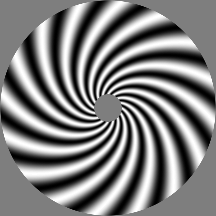

In [37]:
jbh.showIm([stim[i,:,:] for i in stim_idx[40:50]], ncols=5, zoom=.2)


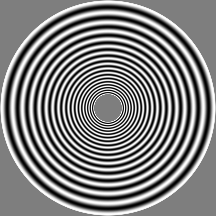
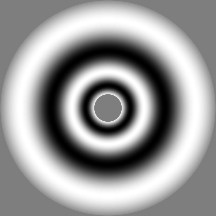
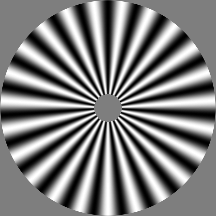
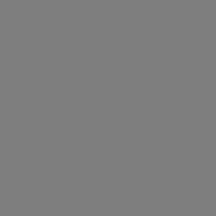
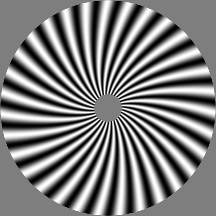
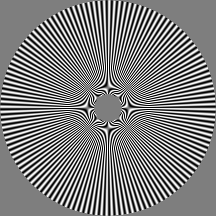
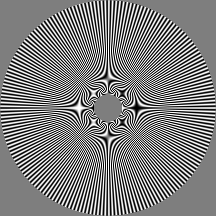
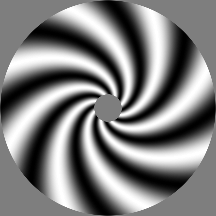
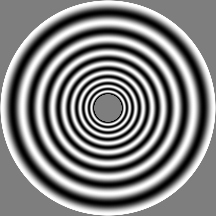
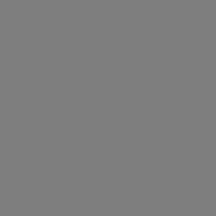

In [39]:
jbh.showIm([stim[i,:,:] for i in stim_idx[50:60]], ncols=5, zoom=.2)


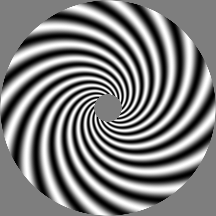
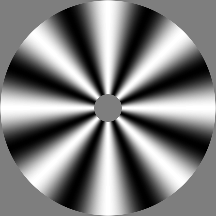

In [40]:
jbh.showIm([stim[i,:,:] for i in stim_idx[60:]], ncols=5, zoom=.2)